In [31]:
# Import required libraries
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
import itertools
import wandb
import argparse
import random

# QOOP-specific imports
from qoop.evolution import normalizer
from qoop.evolution.environment_synthesis import MetadataSynthesis
from qoop.evolution.generator import by_num_rotations_and_cnot
from qoop.evolution.environment import EEnvironment
from qoop.evolution.crossover import onepoint
from qoop.evolution.mutate import bitflip_mutate_with_normalizer
from qoop.evolution.threshold import synthesis_threshold
from qoop.backend.constant import operations_with_rotations
from qoop.evolution import divider


from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
# RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)

In [1]:
! ls -dt1 digits-N6-Cnot3-D6-C20-g200-p0* 

digits-N6-Cnot3-D6-C20-g200-p0.1
digits-N6-Cnot3-D6-C20-g200-p0.07743
digits-N6-Cnot3-D6-C20-g200-p0.05995
digits-N6-Cnot3-D6-C20-g200-p0.04642
digits-N6-Cnot3-D6-C20-g200-p0.03594
digits-N6-Cnot3-D6-C20-g200-p0.02783
digits-N6-Cnot3-D6-C20-g200-p0.02154
digits-N6-Cnot3-D6-C20-g200-p0.01668
digits-N6-Cnot3-D6-C20-g200-p0.01292
digits-N6-Cnot3-D6-C20-g200-p0.01


digits-N6-Cnot3-D6-C20-g200-p0.02154 có tính chất kì lạ. circuit 1 thì ra đầy đủ entanglement các thứ nhưng sau khi tiến hoá thì ra được cái mạch không hề có entanglement. Tức là data này có thể solve một cách linearly được. Và kết quả ra rất tốt 0.79 kém max 0.01. Và thậm chí nó còn không dùng 1 qubits còn lại

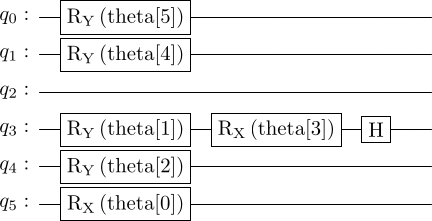

In [6]:
from qiskit.qpy import dump, load
n_features = 4
data_name = "wine"
home = '/home/ducto/workspace/temp/GA-QSVM/'
folder = 'digits-N6-Cnot3-D6-C20-g200-p0.02154'
with open(home + folder + '/best_circuit.qpy', 'rb') as f:
    loaded_circuits = load(f) # qpy.load returns a list of circuits

qc_loaded = loaded_circuits[0]
qc_loaded.draw(output='latex')

In [34]:
# x_vec = [0, 1, 0, 0, 0, 0]
# y_vec = [0, 0, 0, 0, 0, 1]

In [35]:
# from qiskit_machine_learning.state_fidelities import ComputeUncompute
# from qiskit.primitives import Sampler
# fidelity = ComputeUncompute(sampler=Sampler())


In [36]:
# circuit = fidelity.create_fidelity_circuit(qc_loaded, qc_loaded)
# # circuit.draw(output='mpl')
# bound_circuit = circuit.assign_parameters(np.concatenate([x_vec]))

In [37]:
# decomposed_circuit = bound_circuit.decompose()
# decomposed_circuit.draw("mpl")


In [38]:
print(f"Number of qubits in loaded circuit: {qc_loaded.num_qubits}")
print(f"Number of parameters in loaded circuit: {qc_loaded.num_parameters}")
print("Parameters:", qc_loaded.parameters) # Shows the Parameter objects

Number of qubits in loaded circuit: 4
Number of parameters in loaded circuit: 4
Parameters: ParameterView([ParameterVectorElement(theta[0]), ParameterVectorElement(theta[1]), ParameterVectorElement(theta[2]), ParameterVectorElement(theta[3])])


In [39]:
from sklearn.datasets import load_wine, load_digits, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import numpy as np
# Load cancer data using the function from data/split.py
# Number of features should match the number of qubits in the quantum circuit
training_size = 100
test_size = 100


def prepare_cancer_data_split(training_size, test_size, n_features, random_state):
    digits = load_breast_cancer()
    X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=100,train_size=100, random_state=random_state, stratify=digits.target)
    
    # Scale the features 
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Reduce dimensionality using PCA
    pca = PCA(n_components=n_features)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    print(f"Training size: {len(X_train)}, Test size: {len(X_test)}")

    return X_train, X_test, y_train, y_test 

def prepare_wine_data_split(training_size, test_size, n_features, random_state=20):
    wine = load_wine()
    X, y = wine.data, wine.target

    # Split data into training and testing sets BEFORE scaling/PCA
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=100, test_size=78, random_state=random_state, shuffle=True, stratify=y
    )

    print(f"Split complete. Training samples: {len(X_train)}, Test samples: {len(X_test)}")

    # Scale the features (Fit on training data only!)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test) # Transform test data using training scaler

    pca = PCA(n_components=n_features) 
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test) # Transform test data using training PCA

    print(f"PCA complete. Number of features: {X_train.shape[1]}")
    print(f"Final Training size: {len(X_train)}, Final Test size: {len(X_test)}")

    return X_train, X_test, y_train, y_test

def prepare_digits_data_split(training_size, test_size, n_features, binary=False, random_state=55):
    digits = load_digits()
    X, y = shuffle(digits.data, digits.target, random_state=random_state)

    # Split data into training and testing sets BEFORE scaling/PCA
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=100, test_size=100, random_state=random_state, shuffle=True, stratify=y
    )

    print(f"Split complete. Training samples: {len(X_train)}, Test samples: {len(X_test)}")

    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)

    # Scale the features (Fit on training data only!)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test) # Transform test data using training scaler

    # Reduce dimensionality using PCA (Fit on training data only!)
    # Add random_state to PCA if using randomized solvers like 'arpack' or 'randomized'
    pca = PCA(n_components=n_features, random_state=random_state) 
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test) # Transform test data using training PCA

    print(f"PCA complete. Number of features: {X_train.shape[1]}")
    print(f"Final Training size: {len(X_train)}, Final Test size: {len(X_test)}")

    return X_train, X_test, y_train, y_test

dataset = {'digits': prepare_digits_data_split, 'wine': prepare_wine_data_split, 'cancer': prepare_cancer_data_split}
data = dataset[data_name]

In [40]:
results = []
for i in range(100,110):
# for i in range(1000, 1020):

    # Load and prepare cancer dataset
    X_train, X_test, y_train, y_test = data(
        training_size=training_size, 
        test_size=test_size, 
        n_features=n_features, 
        random_state=i
    )

    # Training function adapted from main.py to work with our loaded data
    def train_qsvm(quantum_circuit):
        """
        Train Quantum SVM using the cancer dataset
        
        Args:
            quantum_circuit: Quantum circuit to use as feature map
        
        Returns:
            Classification accuracy
        """
        quantum_kernel = FidelityQuantumKernel(feature_map=quantum_circuit)
        qsvc = QSVC(quantum_kernel=quantum_kernel)
        qsvc.fit(X_train, y_train)
        y_pred = qsvc.predict(X_test)
        return accuracy_score(y_test, y_pred)

    # Train the QSVM with the loaded quantum circuit
    print("Training Quantum SVM with the loaded 7-qubit circuit...")
    accuracy = train_qsvm(qc_loaded)
    results.append(accuracy)
    print(f"Classification accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# print(results)
print(np.mean(results))

Split complete. Training samples: 100, Test samples: 78
PCA complete. Number of features: 4
Final Training size: 100, Final Test size: 78
Training Quantum SVM with the loaded 7-qubit circuit...


Classification accuracy: 0.9615 (96.15%)
Split complete. Training samples: 100, Test samples: 78
PCA complete. Number of features: 4
Final Training size: 100, Final Test size: 78
Training Quantum SVM with the loaded 7-qubit circuit...
Classification accuracy: 0.9359 (93.59%)
Split complete. Training samples: 100, Test samples: 78
PCA complete. Number of features: 4
Final Training size: 100, Final Test size: 78
Training Quantum SVM with the loaded 7-qubit circuit...
Classification accuracy: 0.9744 (97.44%)
Split complete. Training samples: 100, Test samples: 78
PCA complete. Number of features: 4
Final Training size: 100, Final Test size: 78
Training Quantum SVM with the loaded 7-qubit circuit...
Classification accuracy: 0.9487 (94.87%)
Split complete. Training samples: 100, Test samples: 78
PCA complete. Number of features: 4
Final Training size: 100, Final Test size: 78
Training Quantum SVM with the loaded 7-qubit circuit...
Classification accuracy: 0.9744 (97.44%)
Split complete. Tra

In [41]:
# # Create ZFeatureMap circuit
# from qiskit.circuit.library import ZFeatureMap

# # Initialize ZFeatureMap with same number of features as data
# zfm = ZFeatureMap(feature_dimension=n_features)

# results_zfm = []
# # for i in range(1000, 1020):
# for i in range(100,110):
    
#     # Load and prepare dataset
#     X_train, X_test, y_train, y_test = data(
#         training_size=training_size, 
#         test_size=test_size, 
#         n_features=n_features, 
#         random_state=i
#     )

#     # Train QSVM with ZFeatureMap
#     print("Training Quantum SVM with ZFeatureMap circuit...")
#     quantum_kernel = FidelityQuantumKernel(feature_map=zfm)
#     qsvc = QSVC(quantum_kernel=quantum_kernel)
#     qsvc.fit(X_train, y_train)
#     y_pred = qsvc.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     results_zfm.append(accuracy)
#     print(f"Classification accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# print("Average accuracy with ZFeatureMap:", np.mean(results_zfm))


In [42]:

# # Create ZZFeatureMap circuit
# from qiskit.circuit.library import ZZFeatureMap

# # Initialize ZZFeatureMap with same number of features as data
# zzfm = ZZFeatureMap(feature_dimension=n_features)

# results_zzfm = []
# # for i in range(1000, 1020):
# for i in range(100,110):
#     # Load and prepare dataset
#     X_train, X_test, y_train, y_test = data(
#         training_size=training_size, 
#         test_size=test_size, 
#         n_features=n_features, 
#         random_state=i
#     )

#     # Train QSVM with ZZFeatureMap
#     print("Training Quantum SVM with ZZFeatureMap circuit...")
#     quantum_kernel = FidelityQuantumKernel(feature_map=zzfm)
#     qsvc = QSVC(quantum_kernel=quantum_kernel)
#     qsvc.fit(X_train, y_train)
#     y_pred = qsvc.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     results_zzfm.append(accuracy)
#     print(f"Classification accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# print("Average accuracy with ZZFeatureMap:", np.mean(results_zzfm))


In [43]:
# # Train classical SVM with RBF kernel
# from sklearn.svm import SVC

# results_rbf = []
# # for i in range(1000, 1020):
# for i in range(100,110):
    
#     # Load and prepare dataset
#     X_train, X_test, y_train, y_test = data(
#         training_size=training_size, 
#         test_size=test_size, 
#         n_features=n_features, 
#         random_state=i
#     )

#     # Train SVM with RBF kernel
#     print("Training Classical SVM with RBF kernel...")
#     svc = SVC(kernel='rbf')
#     svc.fit(X_train, y_train)
#     y_pred = svc.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     results_rbf.append(accuracy)
#     print(f"Classification accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# print("Average accuracy with RBF kernel:", np.mean(results_rbf))